In [1]:
'''

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/ENEL645/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

'\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/content/gdrive/MyDrive/ENEL645/chest_xray/\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n'

In [2]:
#dataset download and unzipping
#download the dataset from google drive
!wget --no-check-certificate -O '/content/chest_xray_data.zip' 'https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded'
#create a directory for the data
!mkdir -p data
#unzipping the downladed file to get the images 
!unzip -q -n '/content/chest_xray_data.zip' -d '/content/data/chest_xray_data' 

'wget' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file data already exists.
Error occurred while processing: data.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt   
import matplotlib.image as mpimg 
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
#seed(42)

#random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

from tensorflow.random import set_seed
#set_seed(42)

import warnings
warnings.filterwarnings('ignore')
from keras import backend as K
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC, Accuracy, Precision, SensitivityAtSpecificity
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [6]:
#main_path = "/content/data/chest_xray_data/CellData/chest_xray"
#main_path = "G:/My Drive/datasets/xray-pneumonia/chest_xray/chest_xray/"
main_path = "C:/Users/nourn/Desktop/post_grad/winter/machine learning/project/pnemonia/code/data/chest_xray/chest_xray/"
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [32]:
#upsample normal class
df_normal = pd.DataFrame(train_normal, columns=['image'])
df_normal['class'] = 'Normal'

df_pneumonia = pd.DataFrame(train_pneumonia, columns=['image'])
df_pneumonia['class'] = 'Pneumonia'
size_diff = len(df_normal) - len(df_pneumonia)
# If the pneumonia class has fewer samples than normal class
print(len(df_normal))
print(size_diff)
if size_diff > 0:
    # Upsample the pneumonia class to match the size of the normal class
    df_pneumonia_upsampled = resample(df_pneumonia, replace=True, n_samples=size_diff)
    # Concatenate the upsampled pneumonia class with the normal class
    df_train = pd.concat([df_normal, df_pneumonia_upsampled], ignore_index=True)
else:
    # Upsample the normal class to match the size of the pneumonia class
    df_normal_upsampled = resample(df_normal, replace=True, n_samples=-size_diff)
    # Concatenate the upsampled normal class with the pneumonia class
    df_train = pd.concat([df_pneumonia, df_normal_upsampled], ignore_index=True)

1341
-2534


In [8]:
#train_list = [x for x in train_normal]
#train_list.extend([x for x in train_pneumonia])

#df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
#df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [9]:
'''
plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = mpimg.imread(train_normal[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()
'''

'\nplt.figure(figsize=(12,12))\n\nfor i in range(0, 12):\n    plt.subplot(3,4,i + 1)\n    img = mpimg.imread(train_normal[i])\n    plt.imshow(img)\n    plt.axis("off")\n\nplt.tight_layout()\n\nplt.show()\n'

In [31]:

print(len(df_train[df_train['class'] =='Normal']))
print(len(df_train[df_train['class'] =='Pneumonia']))
print(len(df_test))
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])
print(len(train_df))
print(len(train_df[df_train['class'] =='Normal']))
print(len(train_df[df_train['class'] =='Pneumonia']))
len(val_df)

2534
3875
624
5127
2027
3100


1282

In [11]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomZoom,RandomTranslation
from tensorflow.keras.layers import RandomBrightness,RandomContrast
class CustomAugmentation(tf.keras.layers.Layer):
    def __init__(self,preprocessing, rotation_factor=0.05,zoom_factor=0.1,translation_factor=0.05,
                 contrast_factor=0.05,brightness_factor=0.05,**kwargs):
        super(CustomAugmentation, self).__init__(**kwargs)
        self.rotation_factor = rotation_factor
        self.rotation_layer = RandomRotation(factor=self.rotation_factor, fill_mode='constant',fill_value=0)
        self.zoom_layer = RandomZoom(height_factor=zoom_factor,fill_mode='constant',fill_value=0)
        self.translation_layer = RandomTranslation(height_factor=translation_factor,width_factor=translation_factor,fill_mode='constant',fill_value=0)
        self.contrast_layer = RandomContrast(factor=contrast_factor)
        self.brightness_layer = RandomBrightness(factor=brightness_factor)
        self.preprocessing = preprocessing
    def call(self, inputs, training=True):
        if training:
            # randomly choose whether to apply the rotation or not
            if tf.random.uniform(()) < 0.7:
                if tf.random.uniform(()) < 0.3:
                    inputs = self.rotation_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.zoom_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.translation_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.contrast_layer(inputs, training=training)
                if tf.random.uniform(()) < 0.3:
                    inputs = self.brightness_layer(inputs, training=training)

        # if not training or not applying the rotation, return the original image
        return self.preprocessing(inputs)




In [12]:
#model_preprocessing = lambda x: tf.keras.applications.vgg19.preprocess_input(x)
## Generate batches of image data (train, validation, and test) with data augmentation
def create_data_frames(model_preprocessing=None,augmentation=False):
    aug = CustomAugmentation(preprocessing=model_preprocessing)
    if augmentation:
        train_datagen = ImageDataGenerator(aug.call)
    else:
        train_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing)                
    val_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing)
                                        
    test_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing) 



    ds_train = train_datagen.flow_from_dataframe(train_df,
                                                x_col = 'image',
                                                y_col = 'class',
                                                target_size = (IMG_SIZE, IMG_SIZE),
                                                class_mode = 'binary',
                                                batch_size = BATCH,)
                                                #seed = SEED)

    ds_val = val_datagen.flow_from_dataframe(val_df,
                                                x_col = 'image',
                                                y_col = 'class',
                                                target_size = (IMG_SIZE, IMG_SIZE),
                                                class_mode = 'binary',
                                                batch_size = BATCH,
                                                seed = SEED)

    ds_test = val_datagen.flow_from_dataframe(df_test,
                                                x_col = 'image',
                                                y_col = 'class',
                                                target_size = (IMG_SIZE, IMG_SIZE),
                                                class_mode = 'binary',
                                                batch_size = 1,
                                                shuffle = False)
    return ds_train,ds_val,ds_test
#test_generator.reset()

In [13]:
'''
plt.figure(figsize=(12,12))
# retrieve a batch of images from the data generator
x_batch, y_batch = next(ds_train)
# plot the first 9 images in the batch
for i in range(32):
    # define subplot
    plt.subplot(4,8,i + 1)
    # plot raw pixel data
    plt.imshow(x_batch[i])
# show the figure
plt.show()
y_batch
'''

'\nplt.figure(figsize=(12,12))\n# retrieve a batch of images from the data generator\nx_batch, y_batch = next(ds_train)\n# plot the first 9 images in the batch\nfor i in range(32):\n    # define subplot\n    plt.subplot(4,8,i + 1)\n    # plot raw pixel data\n    plt.imshow(x_batch[i])\n# show the figure\nplt.show()\ny_batch\n'

In [23]:
from collections import Counter

t,_,_=create_data_frames()
counter = Counter(t.classes)

print(counter[0])
print(counter[1])
class_weights={0:counter[0]/(counter[0]+counter[1]),1:counter[1]/(counter[0]+counter[1])}
print(class_weights)

Found 5127 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
2027
3100
{0: 0.39535790910864055, 1: 0.6046420908913595}


In [15]:
 #Set up the VGG19 model
def create_model(create_model_function,unfreeze=0):
    #hyper_dimension = 224
    hyper_channels = 3
    base_model = create_model_function()#VGG19(weights='imagenet', include_top=False, input_shape=(hyper_dimension, hyper_dimension, hyper_channels))
    count = 0
    # Freeze the base model layers
    for layer in reversed(base_model.layers):
        if 'conv' in layer.name and count<unfreeze:
            layer.trainable = True
            count+=1
        else:
            layer.trainable = False
    # Add custom head layers for your specific classification task
    x = base_model(base_model.input, training = False)
    x= GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dense(128, activation='relu')(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Compile the model with an optimizer, loss function, and metrics
    model = Model(inputs=base_model.input, outputs=output)
    optimizer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,  loss='binary_crossentropy',  metrics=[Accuracy()])
    trainable_count = int(sum([K.count_params(p) for p in model.trainable_weights]))
    print(f"Total number of trainable parameters: {trainable_count}")
    return model

In [16]:
'''
model_creation = lambda : VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = create_model(model_creation)
model.summary()
'''

"\nmodel_creation = lambda : VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\nmodel = create_model(model_creation)\nmodel.summary()\n"

In [17]:

'''
filepath= "model_cnn1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
e_s = EarlyStopping(monitor='val_loss', patience=20)
'''


'\nfilepath= "model_cnn1.h5"\ncheckpoint = ModelCheckpoint(filepath, monitor=\'val_loss\', verbose=1, save_best_only=True, save_weights_only=False)\ne_s = EarlyStopping(monitor=\'val_loss\', patience=20)\n'

In [18]:
# Train the model
'''
vgg19_model= model.fit(ds_train, 
          steps_per_epoch = len(ds_train),
                              epochs = 20, 
                              validation_data = ds_val,
                              validation_steps = len(ds_val), 
                              verbose=1, batch_size=BATCH, callbacks=[checkpoint,e_s],
                              class_weight=class_weights,
                              )
'''

'\nvgg19_model= model.fit(ds_train, \n          steps_per_epoch = len(ds_train),\n                              epochs = 20, \n                              validation_data = ds_val,\n                              validation_steps = len(ds_val), \n                              verbose=1, batch_size=BATCH, callbacks=[checkpoint,e_s],\n                              class_weight=class_weights,\n                              )\n'

In [19]:
'''
best_model = keras.models.load_model("model_cnn1.h5")
print(best_model.history)
'''

'\nbest_model = keras.models.load_model("model_cnn1.h5")\nprint(best_model.history)\n'

In [20]:
def create_charts(cnn, cnn_model,best,ds_test):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = ds_test.classes
    Y_pred = best.predict_generator(ds_test, steps = len(ds_test))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [21]:
#create_charts(model, vgg19_model,best_model)


VGG no aug only top
Found 5127 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Total number of trainable parameters: 263169
Epoch 1/30
161/161 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.09552, saving model to model_cnn1.h5
161/161 [==============================] - 52s 268ms/step - loss: 0.0781 - accuracy: 0.0000e+00 - val_loss: 0.0955 - val_accuracy: 0.0000e+00
Epoch 2/30
161/161 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 1.9505e-04
Epoch 2: val_loss improved from 0.09552 to 0.07138, saving model to model_cnn1.h5
161/161 [==============================] - 44s 271ms/step - loss: 0.0356 - accuracy: 1.9505e-04 - val_loss: 0.0714 - val_accuracy: 7.8003e-04
Epoch 3/30
161/161 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 9.7523e-04
Epoch 3: 

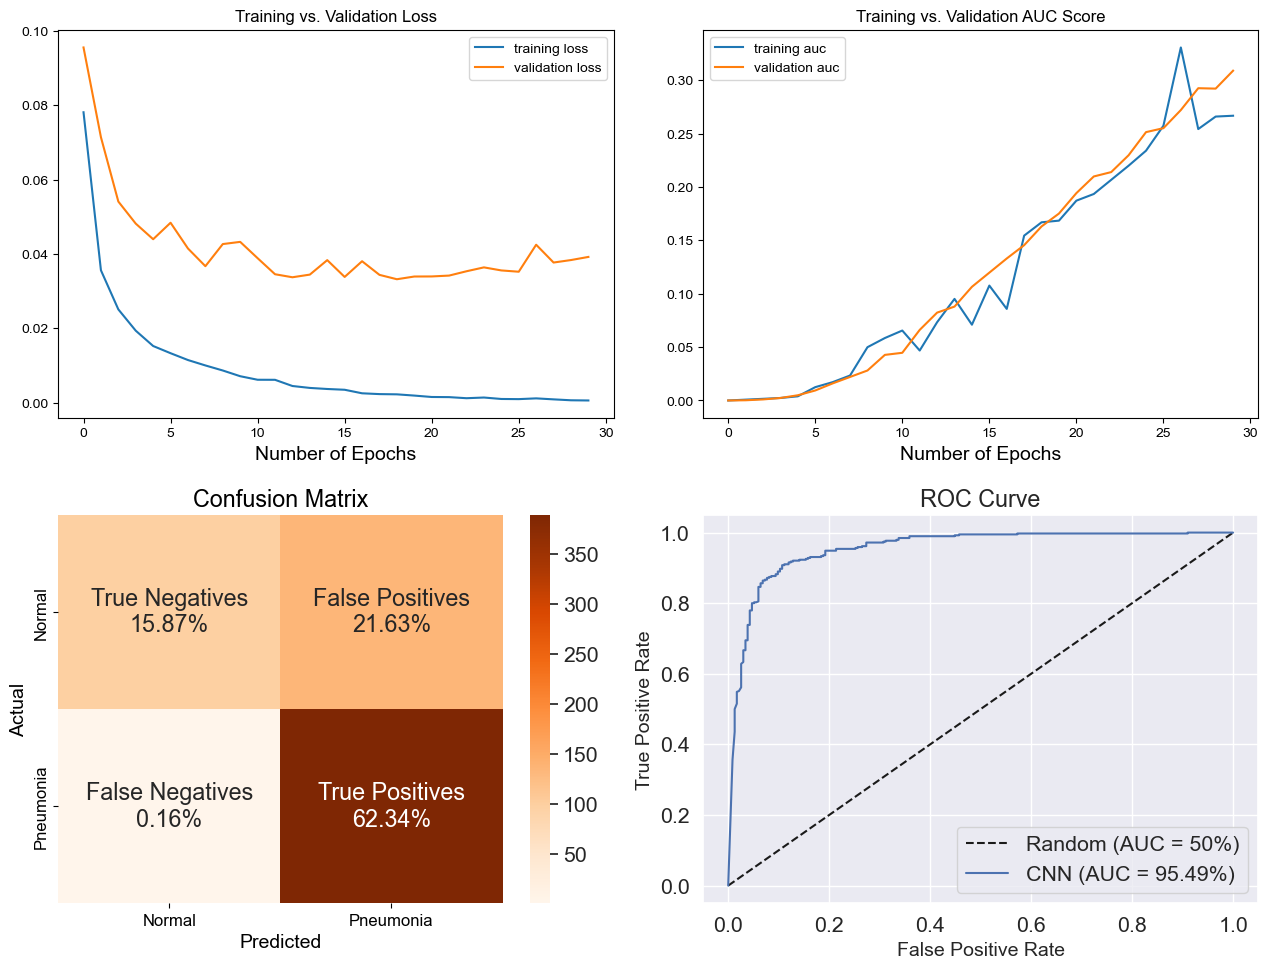

In [22]:
#set up different tests
#vgg19
def run(model_type,class_type,unfreeze=0,augm=False,dim=224):
    model_preprocessing = lambda x: class_type.preprocess_input(x)
    ds_train,ds_val,ds_test = create_data_frames(model_preprocessing,augm)
    filepath= "model_cnn1.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
    e_s = EarlyStopping(monitor='val_loss', patience=20)
    model_creation = lambda : model_type(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))
    model = create_model(model_creation,unfreeze=unfreeze)
    result_model= model.fit(ds_train, 
            steps_per_epoch = len(ds_train),
                                epochs = 30, 
                                validation_data = ds_val,
                                validation_steps = len(ds_val), 
                                verbose=1, batch_size=BATCH, callbacks=[checkpoint,e_s],
                                class_weight=class_weights,
                                shuffle=True
                                )
    best_model = keras.models.load_model("model_cnn1.h5")
    create_charts(model, result_model,best_model,ds_test)


print("VGG no aug only top")
run(VGG19,tf.keras.applications.vgg19)
# print("VGG aug only top")
# run(VGG19,tf.keras.applications.vgg19,augm=True)
# print("VGG no aug unfreeze 2 layers")
# run(VGG19,tf.keras.applications.vgg19,unfreeze=2)
# print("VGG aug only top unfreeze 2 layers")
# run(VGG19,tf.keras.applications.vgg19,augm=True,unfreeze=2)

# print("inception_v3 no aug only top")
# run(tf.keras.applications.inception_v3.InceptionV3,tf.keras.applications.inception_v3,dim=299)
# print("inception_v3 aug only top")
# run(tf.keras.applications.inception_v3.InceptionV3,tf.keras.applications.inception_v3,dim=299,augm=True)
# print("inception_v3 no aug unfreeze 2 layers")
# run(tf.keras.applications.inception_v3.InceptionV3,tf.keras.applications.inception_v3,dim=299,unfreeze=2)
# print("inception_v3 aug only top unfreeze 2 layers")
# run(tf.keras.applications.inception_v3.InceptionV3,tf.keras.applications.inception_v3,dim=299,augm=True,unfreeze=2)
